# QA A/B test schema post-deployment
Jun, 2023

## TICKETS:
- Instumentation planning :    
      Spec: [T333222](https://phabricator.wikimedia.org/T333222)

- Instrumentation deployment :  
 Launch AB test: [T335972](https://phabricator.wikimedia.org/T335972)    
 Fix bug: [T336969](https://phabricator.wikimedia.org/T336969)

- Data tickets:    
__Data QA__: [T336299](https://phabricator.wikimedia.org/T336299)


In [20]:
shhh <- function(expr) suppressPackageStartupMessages(suppressWarnings(suppressMessages(expr)))
shhh({
library(tidyverse); 
library(lubridate); 
library(scales);
library(magrittr); 
library(dplyr);
})

In [21]:
library(IRdisplay)

display_html(
'<script>  
code_show=true; 
function code_toggle() {
  if (code_show){
    $(\'div.input\').hide();
  } else {
    $(\'div.input\').show();
  }
  code_show = !code_show
}  
$( document ).ready(code_toggle);
</script>
  <form action="javascript:code_toggle()">
    <input type="submit" value="Click here to toggle on/off the raw code.">
 </form>'
)

In [22]:
options(repr.plot.width = 15, repr.plot.height = 10)

## Check sessions are assigned in both groups

In [2]:
query_check_duplicate <- "
WITH t_duplicate AS
(SELECT  web_session_id, wiki, count(distinct `group` ) AS groups,  min(meta.dt) AS session_dt 
FROM event.mediawiki_web_ab_test_enrollment
WHERE year=2023 and month IN (5,6)
AND wiki  IN ('hewiki', 'enwiki', 'fawiki', 'frwiki', 'kowiki', 'ptwiki', 'srwiki', 
'thwiki', 'trwiki', 'viwiki') 
AND CONCAT(year, '-', LPAD(month,2,'0'),'-', LPAD(day,2,'0')) BETWEEN '2023-06-02' AND '2023-06-19'
GROUP BY  web_session_id, wiki
HAVING groups>1
)
SELECT wiki, count(web_session_id) AS dup_sessions
FROM t_duplicate
GROUP BY wiki
"

In [3]:
df_duplicate <- wmfdata::query_hive(query_check_duplicate)

Don't forget to authenticate with Kerberos using kinit



In [4]:
df_duplicate 

wiki,dup_sessions
<chr>,<int>
enwiki,1142
fawiki,81
frwiki,130
hewiki,40
kowiki,25
ptwiki,80
srwiki,10
thwiki,15
trwiki,38


### Note
Above sessions will be excluded in analysis

### One example

In [10]:
query <- "
SELECT *
FROM event.mediawiki_web_ab_test_enrollment
WHERE year=2023 and month IN (5,6)
AND wiki='enwiki'
AND CONCAT(year, '-', LPAD(month,2,'0'),'-', LPAD(day,2,'0')) BETWEEN '2023-06-02' AND '2023-06-19'
AND web_session_id='03a6e397ee1f3c0ab735'
ORDER BY dt
LIMIT 10000
"

In [11]:
df_test <- wmfdata::query_hive(query)

Don't forget to authenticate with Kerberos using kinit



## Check bucketing of non-duplicated sessions

In [13]:
query_non_duplicate <- "
WITH t_ab_no_duplicate AS
(SELECT  web_session_id, wiki, meta.domain AS domain, count(distinct `group` ) AS groups,  min(meta.dt) AS session_dt 
FROM event.mediawiki_web_ab_test_enrollment
WHERE wiki IN ('hewiki', 'enwiki', 'fawiki', 'frwiki', 'kowiki', 'ptwiki', 'srwiki', 
'thwiki', 'trwiki', 'viwiki') and year=2023 and month = 6
AND CONCAT(year, '-', LPAD(month,2,'0'),'-', LPAD(day,2,'0')) BETWEEN '2023-06-02' AND '2023-06-19'
GROUP BY  web_session_id, wiki,  meta.domain
-- exclude session ids are in both control and treatment group
HAVING groups < 2
)
SELECT 
 t1.web_session_id,
 t1.wiki,t1.meta.domain AS domain,
 t1.`group` AS test_group,
 min(t1.meta.dt) AS session_dt 
FROM event.mediawiki_web_ab_test_enrollment AS t1
INNER JOIN t_ab_no_duplicate AS t2 ON t1.wiki=t2.wiki 
AND t1.web_session_id=t2.web_session_id 
WHERE t1.wiki  IN ('hewiki', 'enwiki', 'fawiki', 'frwiki', 'kowiki', 'ptwiki', 'srwiki', 
'thwiki', 'trwiki', 'viwiki')  and t1.year=2023 and t1.month=6 
AND CONCAT(t1.year, '-', LPAD(t1.month,2,'0'),'-', LPAD(t1.day,2,'0')) BETWEEN '2023-06-02' AND '2023-06-19'
GROUP BY  t1.web_session_id, t1.wiki,t1.meta.domain, t1.`group`
" 
  

In [14]:
df_non_duplicate <- wmfdata::query_hive(query_non_duplicate)

Don't forget to authenticate with Kerberos using kinit



In [18]:
df_non_duplicate  %>%
        group_by(wiki, test_group) %>% 
        summarize(sessions=n_distinct(web_session_id), .groups='drop')

wiki,test_group,sessions
<chr>,<chr>,<int>
enwiki,control,520996
enwiki,treatment,478293
fawiki,control,11579
fawiki,treatment,10980
frwiki,control,66111
frwiki,treatment,62048
hewiki,control,10598
hewiki,treatment,11359
kowiki,control,5895


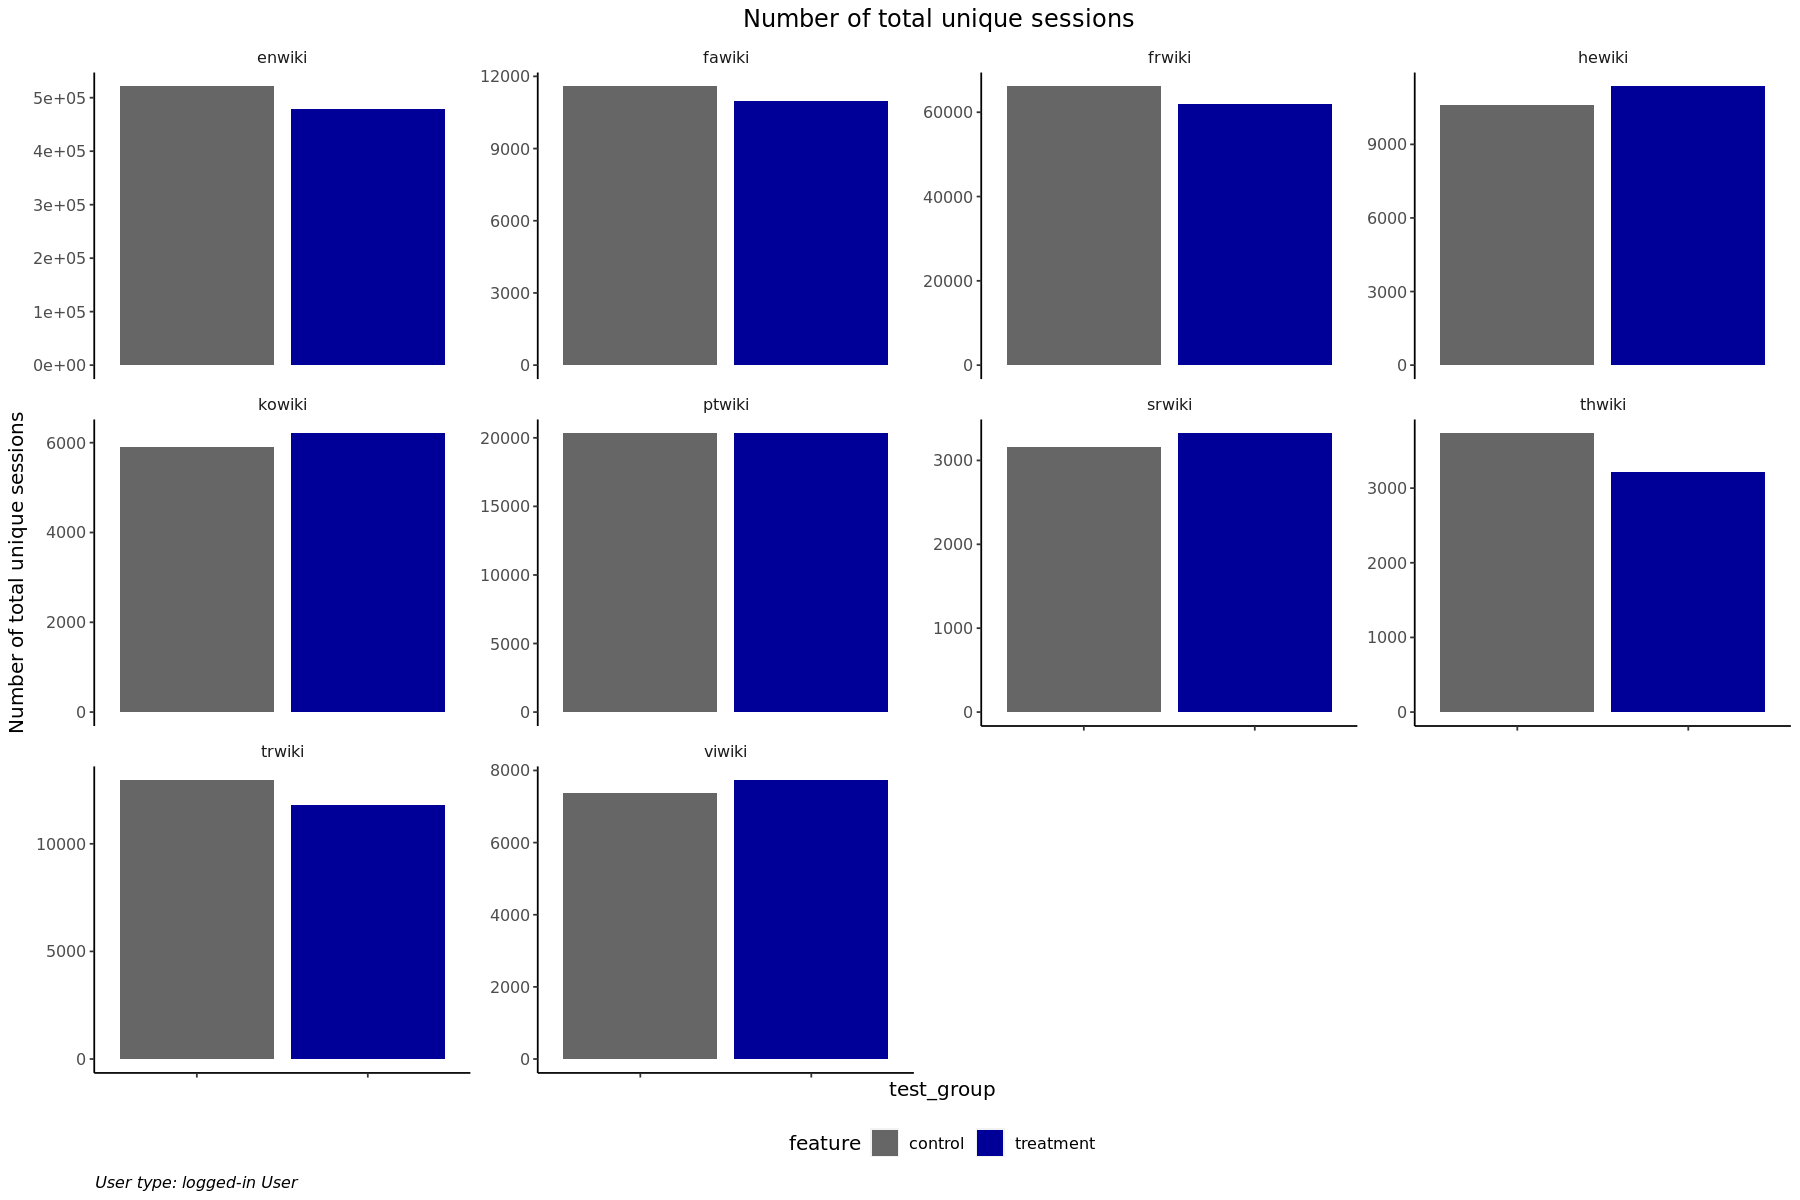

In [23]:

barchart_sessions_overall  <- df_non_duplicate  %>%
        group_by(wiki, test_group) %>% 
        summarize(sessions=n_distinct(web_session_id), .groups='drop') %>%
        ggplot(aes(x = test_group, y= sessions, fill=test_group)) +
        geom_bar(stat="identity", position = 'dodge') +
        #geom_text(aes(label = paste(scrolls_per_pv)), color = "black", position = position_dodge(0.9), vjust =0, size = 3) +
        facet_wrap(~wiki, scale = 'free_y') +
        labs (
              y = "Number of total unique sessions" ,
             title = "Number of total unique sessions " ,
             caption = "User type: logged-in User" ) +
     scale_fill_manual(values= c( "#666666",  "#000099"), name = "feature")  +
         theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            axis.text.x = element_blank(),
            plot.caption = element_text(hjust = 0, face= "italic"),
            strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=12),
            axis.line = element_line(colour = "black"),
            legend.position = "bottom")
barchart_sessions_overall
     

### Note

Bucketing is balanced.

## Check session switches skin preference

In [24]:
query_skin <- "
select skin, count(1)
from event.mediawiki_web_ab_test_enrollment
WHERE wiki IN ('hewiki', 'enwiki', 'fawiki', 'frwiki', 'kowiki', 'ptwiki', 'srwiki', 
'thwiki', 'trwiki', 'viwiki') and year=2023 and month = 6 
AND CONCAT(year, '-', LPAD(month,2,'0'),'-', LPAD(day,2,'0')) BETWEEN '2023-06-02' AND '2023-06-19'
AND experiment_name='skin-vector-zebra-experiment'
GROUP BY skin
"


In [25]:
df_skin <- wmfdata::query_hive(query_skin)

Don't forget to authenticate with Kerberos using kinit



In [26]:
df_skin

skin,X_c1
<chr>,<int>
NULL,1
vector-2022,20375167


### Note

Need to exclude the session which is not in vector-2022 skin.

## Check if only logged-users in experiment, need to exclude anonymous users

In [27]:
query_isanon<- "
select is_anon, count(1)
from event.mediawiki_web_ab_test_enrollment
WHERE wiki IN ('hewiki', 'enwiki', 'fawiki', 'frwiki', 'kowiki', 'ptwiki', 'srwiki', 
'thwiki', 'trwiki', 'viwiki') and year=2023 and month = 6 
AND CONCAT(year, '-', LPAD(month,2,'0'),'-', LPAD(day,2,'0')) BETWEEN '2023-06-02' AND '2023-06-19'
AND experiment_name='skin-vector-zebra-experiment'
GROUP BY is_anon
"


In [28]:
df_isanon <- wmfdata::query_hive(query_isanon)

Don't forget to authenticate with Kerberos using kinit



In [29]:
df_isanon

is_anon,X_c1
<chr>,<int>
false,20375168


### Note

No anonymous users are enrolled in experiment, which is expected.

## Check how many bot users in experiment, need to exclude bots.

In [30]:
query_isbot<- "
select is_bot, count(1)
from event.mediawiki_web_ab_test_enrollment
WHERE wiki IN ('hewiki', 'enwiki', 'fawiki', 'frwiki', 'kowiki', 'ptwiki', 'srwiki', 
'thwiki', 'trwiki', 'viwiki') and year=2023 and month = 6 
AND CONCAT(year, '-', LPAD(month,2,'0'),'-', LPAD(day,2,'0')) BETWEEN '2023-06-02' AND '2023-06-19'
AND experiment_name='skin-vector-zebra-experiment'
GROUP BY is_bot
"

In [31]:
df_isbot <- wmfdata::query_hive(query_isbot)

Don't forget to authenticate with Kerberos using kinit



In [32]:
df_isbot 

is_bot,X_c1
<chr>,<int>
false,20374702
true,466


### Note

Need to exclude 466 sessions from bot users in analysis.